In [1]:
#группа 1 -контроль группа 2 - новые алгоритмы(таргет)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandahouse
import numpy as np
import hashlib #делать хэши
#import swifter #ускорение метода apply
from scipy import stats #статистика
%matplotlib inline

In [3]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20220520'
     }

q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM simulator_20220520.feed_actions 
WHERE toDate(time) between '2022-04-24' and '2022-04-30'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""
df = pandahouse.read_clickhouse(q, connection=connection)


 t-тест, Пуассоновский бутстреп, тест Манна-Уитни, t-тест на сглаженном ctr (α=5), а также t-тест и тест Манна-Уитни поверх бакетного преобразования

Распределения

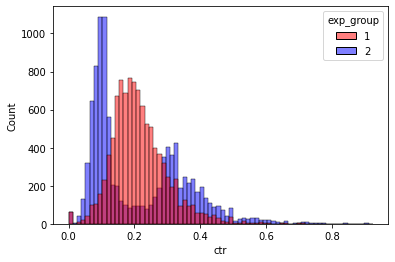

In [4]:
#sns.set(rc={'figure.figsize':(11.7,8.27)})
groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

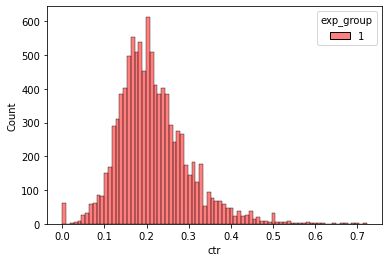

In [5]:
#sns.set(rc={'figure.figsize':(11.7,8.27)})
groups = sns.histplot(data = df[df.exp_group == 1], 
              x='ctr', 
              hue='exp_group', 
              palette = ['r'],
              alpha=0.5,
              kde=False)

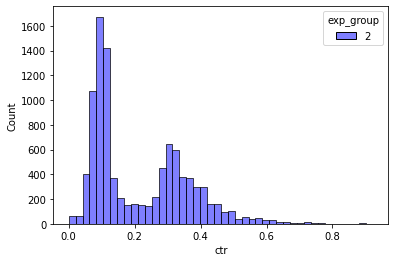

In [7]:
groups = sns.histplot(data = df[df.exp_group == 2], 
              x='ctr', 
              hue='exp_group', 
              palette = ['b'],
              alpha=0.5,
              kde=False)

T-тест

In [8]:
t_test=stats.ttest_ind(
        df[df.exp_group == 1].ctr,
        df[df.exp_group == 2].ctr,
          equal_var=False) 
print(t_test)

Ttest_indResult(statistic=0.7094392041270485, pvalue=0.4780623130874935)


Тест Манна-Уитни

In [9]:
mw_test=stats.mannwhitneyu(df[df.exp_group == 1].ctr,
                         df[df.exp_group == 2].ctr,
                           alternative = 'two-sided') 
print(mw_test)

MannwhitneyuResult(statistic=56601260.5, pvalue=6.0376484617779035e-56)


In [10]:
A_gt_B = 0
for _ in range(10000):
    A_gt_B+= df[df.exp_group == 1].ctr.sample().values[0] > df[df.exp_group == 2].ctr.sample().values[0]
    
print('В', A_gt_B/100, '% случаев A > B. Должно получиться около 50%')

В 56.55 % случаев A > B. Должно получиться около 50%


T-тест на сглаженном ctr (α=5)

In [11]:
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

In [12]:
global_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()
global_ctr_2 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()

In [13]:
group1 = df[df.exp_group == 1].copy()
group2 = df[df.exp_group == 2].copy()

In [14]:
#Сглаженный CTR, группа 1

/nfs/env/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='ctr'>

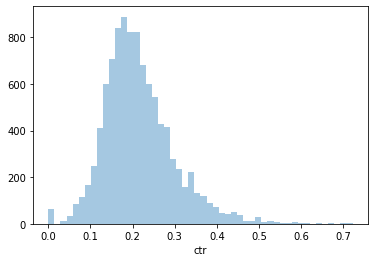

In [15]:
sns.distplot(group1.ctr,
             kde = False)

In [16]:
#Сглаженный CTR, группа 2

<AxesSubplot:xlabel='ctr'>

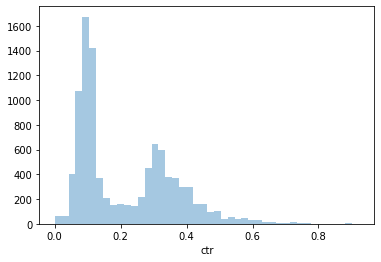

In [17]:
sns.distplot(group2.ctr,
             kde = False)

In [18]:
group1['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)

group2['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)

In [19]:
t_test_smtothed_ctr=stats.ttest_ind(
                              group1['smothed_ctr'],
                              group2['smothed_ctr'],
                                   equal_var=False) 
print(t_test_smtothed_ctr)

Ttest_indResult(statistic=2.2841320431616983, pvalue=0.0223769815558559)


Пуассоновский бутстреп

In [20]:
#Функция бутстрепа
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

In [21]:
likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

<AxesSubplot:ylabel='Count'>

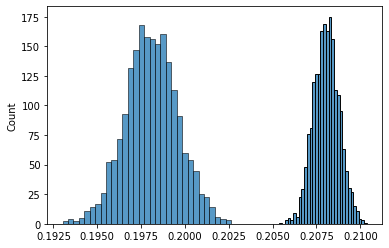

In [23]:
#Графики распределения выборок, полученных бустрепом ctr1 и ctr2
sns.histplot(ctr1)
sns.histplot(ctr2)

<AxesSubplot:ylabel='Count'>

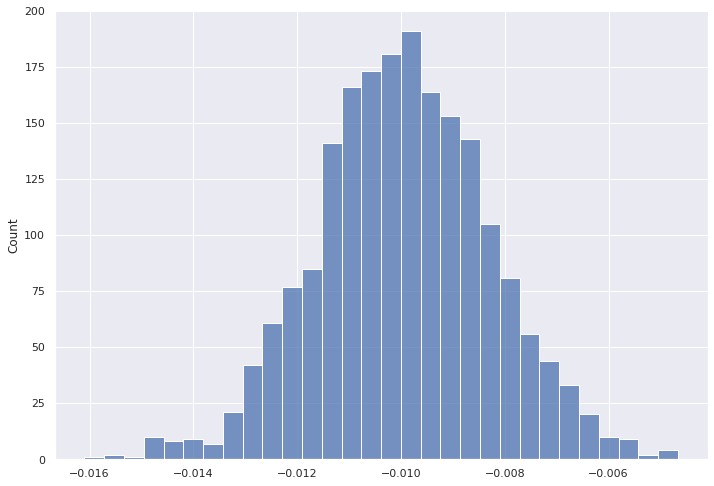

In [36]:
#Разница между глобальными CTR, проученных бутстрепом
sns.histplot(ctr2 - ctr1, bins=30)

Бакетное преобразование

In [25]:
#Формируем бакеты
q = """

SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr,
    quantileExact(0.9)(ctr) as ctr9
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM  simulator_20220520.feed_actions 
    WHERE toDate(time) between '2022-04-17' and '2022-04-23'
        and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""
df = pandahouse.read_clickhouse(q, connection=connection)


In [26]:
#ctr1 и сtr2 полученные после бакетного преобразования

<AxesSubplot:xlabel='bucket_ctr', ylabel='Count'>

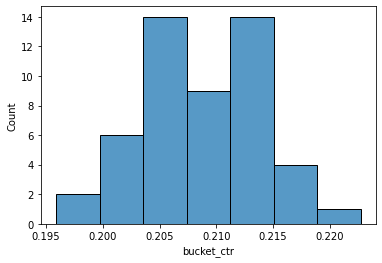

In [32]:
sns.histplot(df[df.exp_group == 1].bucket_ctr)

<AxesSubplot:xlabel='bucket_ctr', ylabel='Count'>

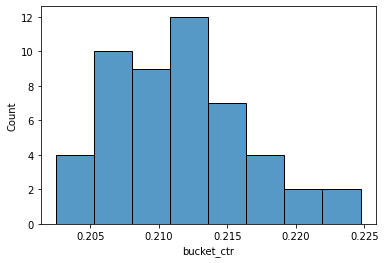

In [33]:
sns.histplot(df[df.exp_group == 2].bucket_ctr)

T-Тест поверх бакетного преобразования

In [29]:
t_test_bucket=stats.ttest_ind(df[df.exp_group == 1].bucket_ctr, 
                              df[df.exp_group == 2].bucket_ctr, 
                              equal_var = False)
print(t_test_bucket)

Ttest_indResult(statistic=-2.249431215012112, pvalue=0.026727457897151256)


Тест Манна-Уитни поверх бакетного преобразования

In [30]:
#тест Манна-Уитни
mw_test_bucket=stats.mannwhitneyu(df[df.exp_group == 1].bucket_ctr, 
                             df[df.exp_group == 2].bucket_ctr, 
                                    alternative = 'two-sided')
print(mw_test_bucket)

MannwhitneyuResult(statistic=950.0, pvalue=0.0389514842806052)


Выводим все тесты:

In [31]:
print('p-value t-тест:', t_test[1])

print('p-value Манна-Уитни:', mw_test[1])

print('p-value t-тест на сглаженном ctr (α=5):',t_test_smtothed_ctr[1])

print('p-value t-тест поверх бакетного преобразования:', t_test_bucket[1])

print('p-value тест Манна-Уитни поверх бакетного преобразования:', mw_test_bucket[1])

p-value t-тест: 0.4780623130874935
p-value Манна-Уитни: 6.0376484617779035e-56
p-value t-тест на сглаженном ctr (α=5): 0.0223769815558559
p-value t-тест поверх бакетного преобразования: 0.026727457897151256
p-value тест Манна-Уитни поверх бакетного преобразования: 0.0389514842806052


Выводы: Все тесты за исключением t-теста показали наличие статистически значимых различий между группами 1 и 2 по метрике ctr. Разница между ctr, полученная методом Бутстрепа не содержит нуля. Т.е бутстреп также свидетельствует о наличии различий. 
Визуально распределение в группе 2 (новые рекомендациии) отличаются от нормального, поэтому здесь t-теста не показал различий. Нарушено требование t-теста к нормальности распределения. 
Требования теста Манна -Уитни к нормальности не строги, поэтому статистические различия были обнаружены. 

На графике видно, что исходная выборка 2 двумодальна, что и дает сильные искажения. Возможно при разбивке пользователей на группы не был учтен какой -то параметр, например характер трафика, который сгенерировал новых пользоватлей, что и привело к 2 модам в распределении. Скажем, CTR пользователей органического трафика больше CTR рекламного. 

Считаю, что не стоит раскатывать новый алогоритм на новых пользователей, стоит взять выборки с более нормальным и однородным распределением, и провести новый АБ тест.
